In [1]:
import os

model_path = os.environ["DATA"] + "/08_XAI/01.01_stability_learning/model.pkl"
test_set_path = os.environ["DATA"] + "/00_datasets/DFT/stability/test_set.csv"
all_OD9_shingles_dict_path_own = os.environ["DATA"] + "/00_datasets/DFT/stability/all_OD9_shingles_dict_own.json"

output_optim_path = os.environ["DATA"] + "/08_XAI/01.01_stability_learning/experiments"

In [2]:
import pandas as pd

def load_dataset(csv_path, first_col=None):
    df = pd.read_csv(csv_path, header=None)
    if first_col is not None:
        df.drop(np.arange(0, first_col), axis=1, inplace=True)
    
    return df.to_numpy()


In [3]:
import json
import joblib

model_rf = joblib.load(model_path)
test_set_data = load_dataset(test_set_path)

with open(all_OD9_shingles_dict_path_own, "r") as f:
    shingles_dict = json.load(f)

In [4]:
from bbomol.descriptor import ShinglesVectDesc
desc_builder_g = ShinglesVectDesc(vect_size=1000, external_desc_id_dict=shingles_dict)

MM program : obabel


In [5]:
from evomol.evaluation import EvaluationStrategy
import numpy as np
from guacamol.common_scoring_functions import TanimotoScoringFunction

class ShinglesTanimotoSimilarity(EvaluationStrategy):
    
    def __init__(self, target_smiles, desc_builder):
        super().__init__()
        self.target_smiles = target_smiles
        self.desc_builder = desc_builder
        self.target_desc = desc_builder.fit_transform([target_smiles])[0][0].astype(bool)
        
    def keys(self):
        return ["shingles_tanimoto"]
        
    def evaluate_individual(self, individual, to_replace_idx=None):
        candidate_desc = self.desc_builder.fit_transform([individual.to_aromatic_smiles()])[0][0].astype(bool)
        intersect = np.logical_and(self.target_desc, candidate_desc)
        value = np.sum(intersect)/(np.sum(self.target_desc) + np.sum(candidate_desc) - np.sum(intersect)) 
        return value, [value]
    
class ECFP4TanimotoSimilarity(EvaluationStrategy):
    
    def __init__(self, target_smiles):
        super().__init__()
        self.target_smiles = target_smiles
        self.guacamol_scorer = TanimotoScoringFunction(target_smiles, "ECFP4") 
        
    def keys(self):
        return ["ecfp4_tanimoto"]
        
    def evaluate_individual(self, individual, to_replace_idx=None):
        value = self.guacamol_scorer.score_mol(MolFromSmiles(individual.to_aromatic_smiles()))
        return value, [value]
    

In [6]:
class ModelProbabilityObjective(EvaluationStrategy):
    
    def __init__(self, model, desc_builder):
        super().__init__()
        self.model = model
        self.desc_builder = desc_builder
        
    def keys(self):
        return ["model_proba_obj"]
    
    def evaluate_individual(self, individual, to_replace_idx=None):
        
        desc = self.desc_builder.fit_transform([individual.to_aromatic_smiles()])[0][0]
        proba_neg = model_rf.predict_proba(desc.reshape(1, -1))[0][0]
        val = min(1, 2*proba_neg)
        return val, [val]

In [7]:
def obj_fun_builder(target_smiles):
    
    return {
        "type": "mean",
        "functions":{
#             ShinglesTanimotoSimilarity(target_smiles, desc_builder_g),
            ECFP4TanimotoSimilarity(target_smiles),
            ModelProbabilityObjective(model_rf, desc_builder_g)
        }
    }

In [8]:
from evomol.evaluation_dft import smi_to_filename
from os.path import join
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem import MolFromSmiles
from IPython.utils import io
from evomol import run_model

def run_exp(smi, use_instance_as_starting_point):
    with io.capture_output() as captured:
        
        exp_dict = {
            "obj_function": obj_fun_builder(smi),
            "io_parameters":{
                "model_path": join(output_optim_path, smi_to_filename(smi))
            },
            "optimization_parameters":{
                "max_steps": 300
            }
        }
        
        if use_instance_as_starting_point:
            exp_dict["io_parameters"]["smiles_list_init"] = [smi] # Default case : methane as starting point

        run_model(exp_dict)
    
    df = pd.read_csv(join(output_optim_path, smi_to_filename(smi), "pop.csv"))
    
    # Keeping only solutions that are predicted negative
    df = df[df["model_proba_obj"] == 1]
    
    # Sorting by descending similarity
    df = df.sort_values("total", ascending=False)
    
    selected_solutions = df["smiles"][:8].tolist()
    
    str_class = ["negative" for i in range(8)]
    
    selected_solutions.insert(4, smi)
    str_class.insert(4, "positive")
    
    return MolsToGridImage([MolFromSmiles(s) for s in selected_solutions], legends=str_class)

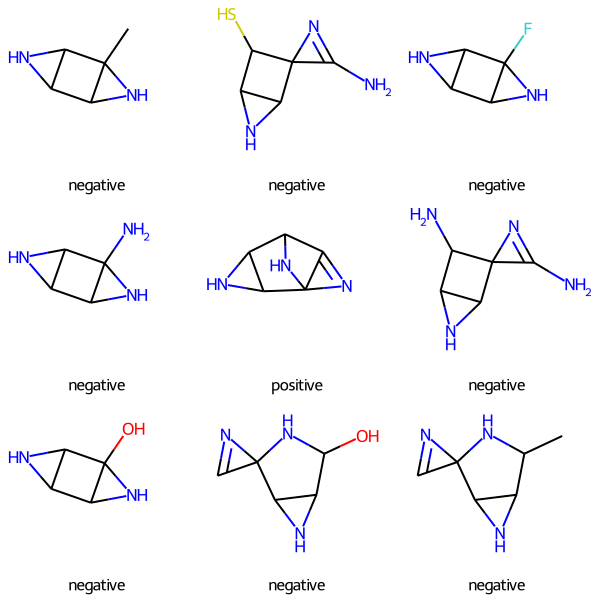

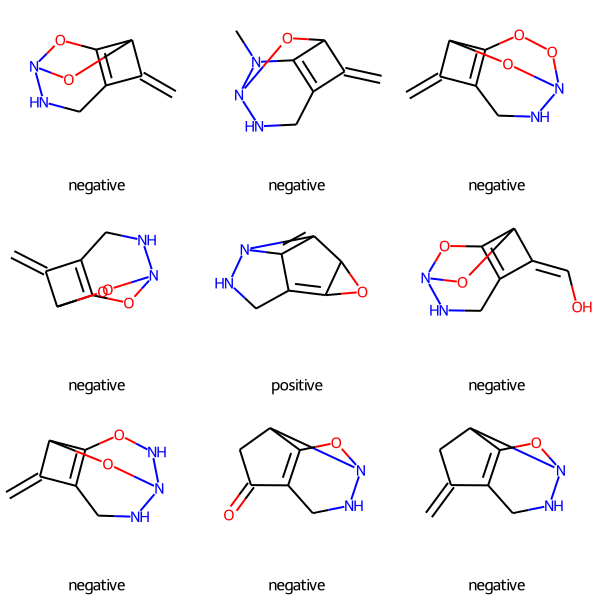

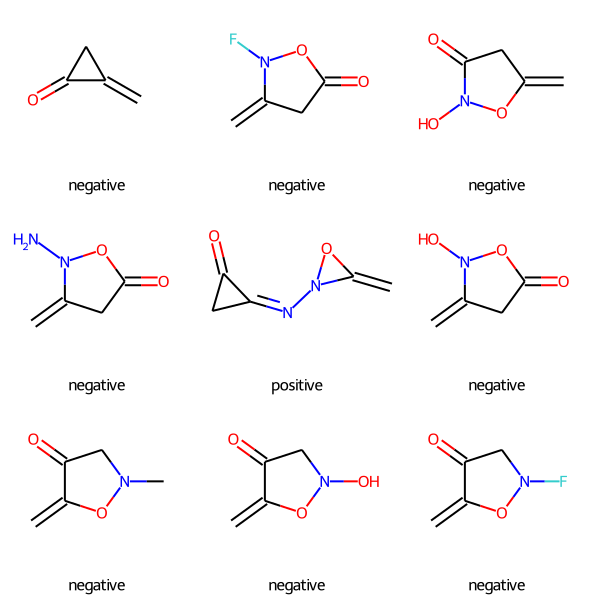

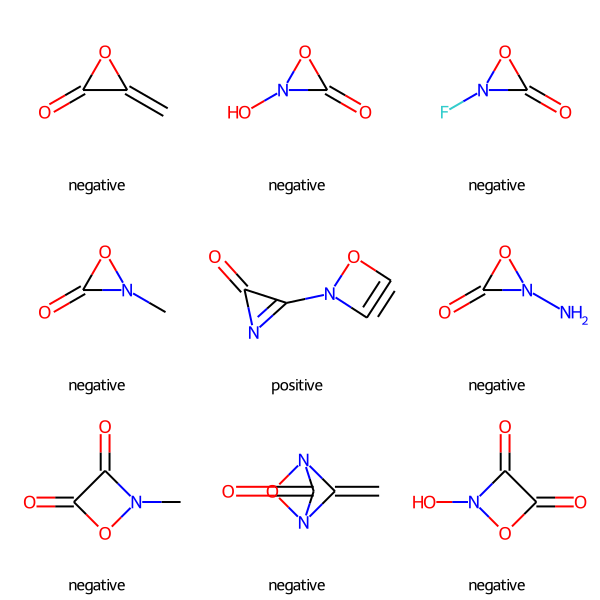

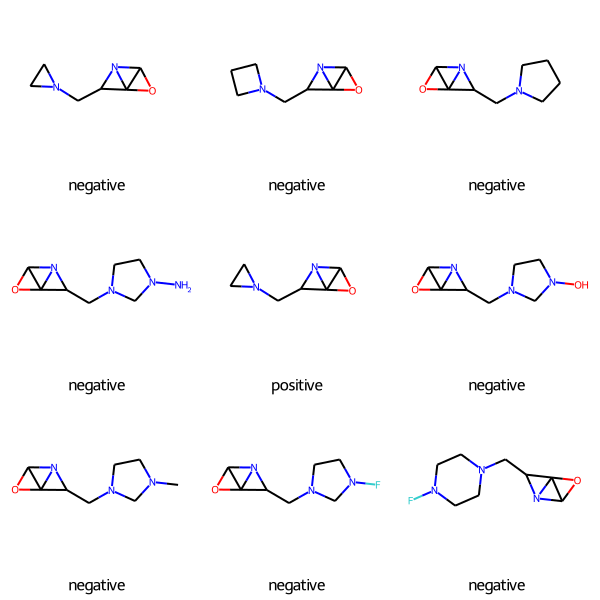

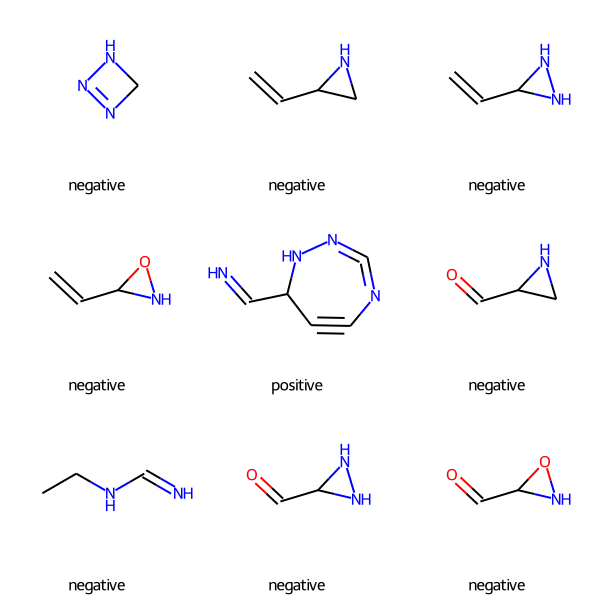

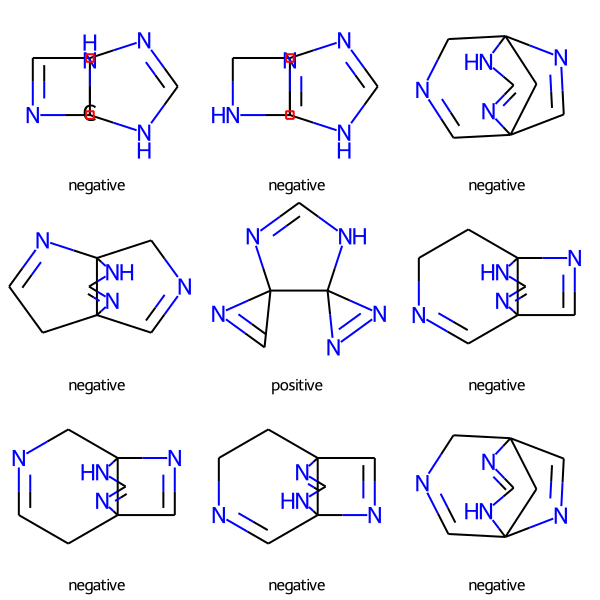

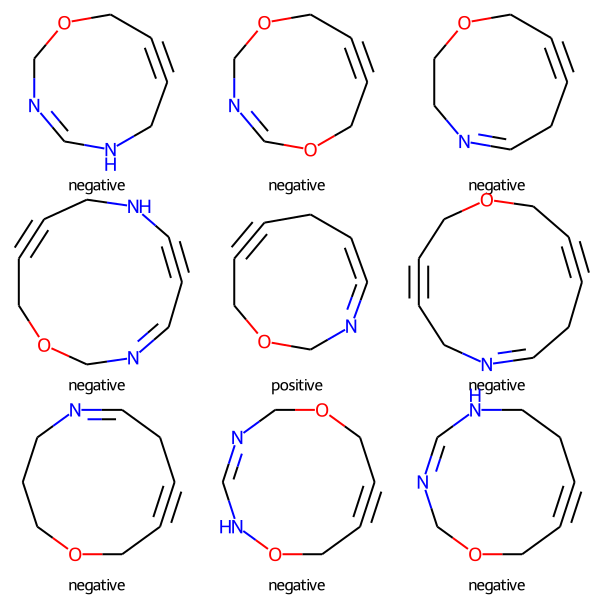

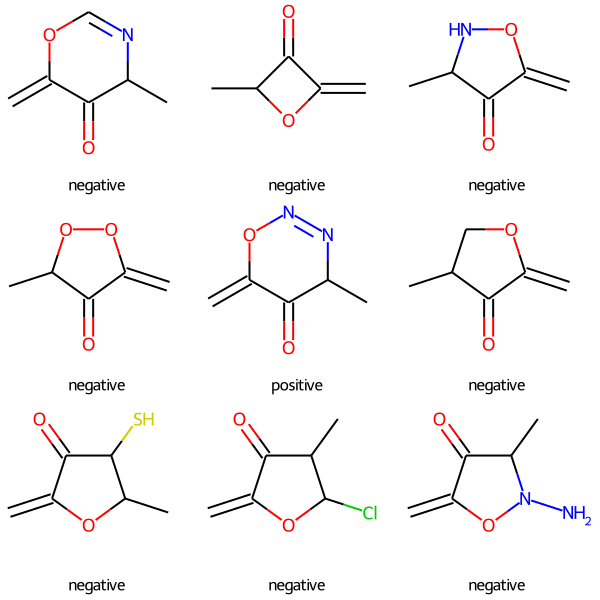

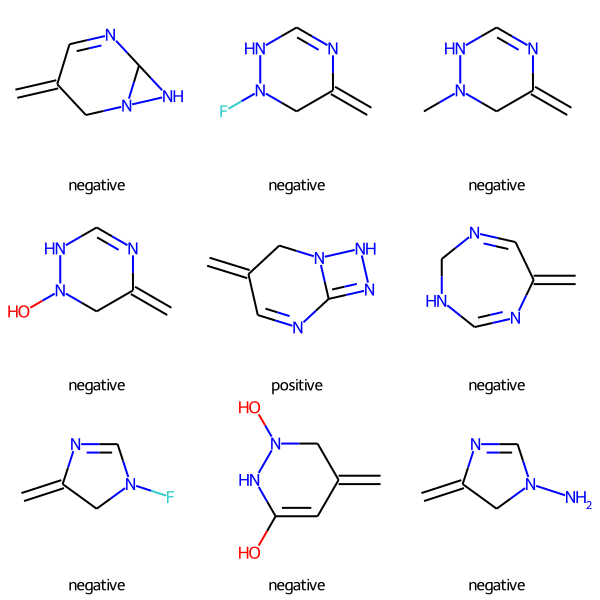

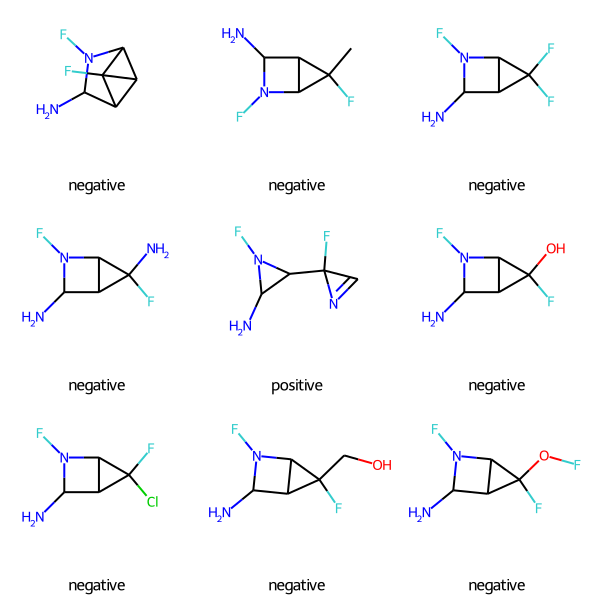

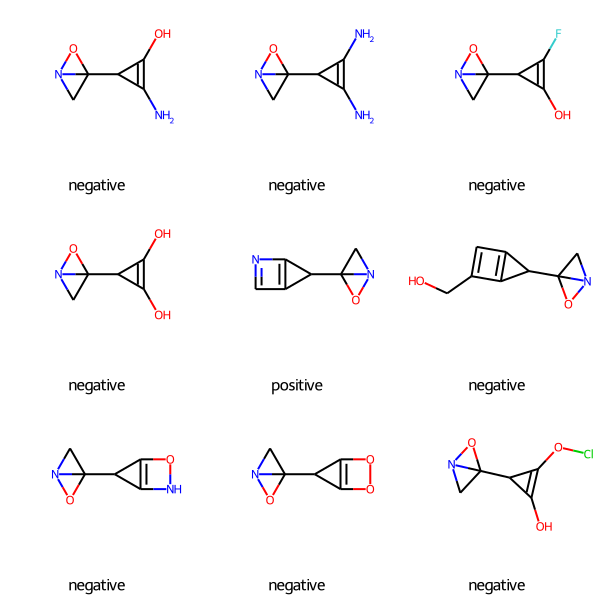

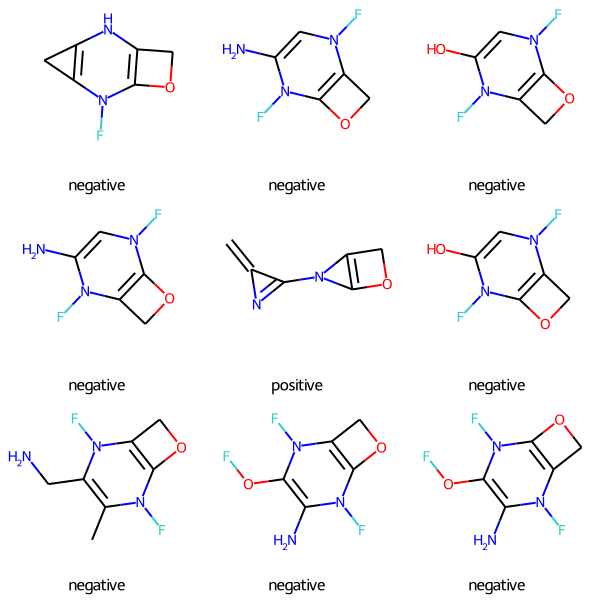

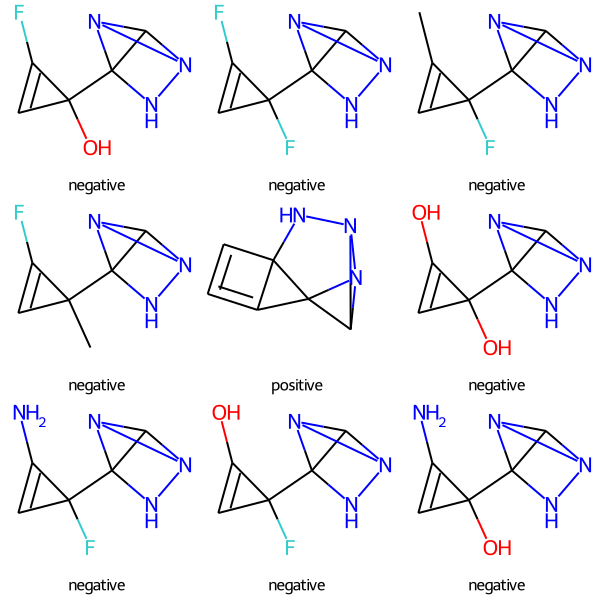

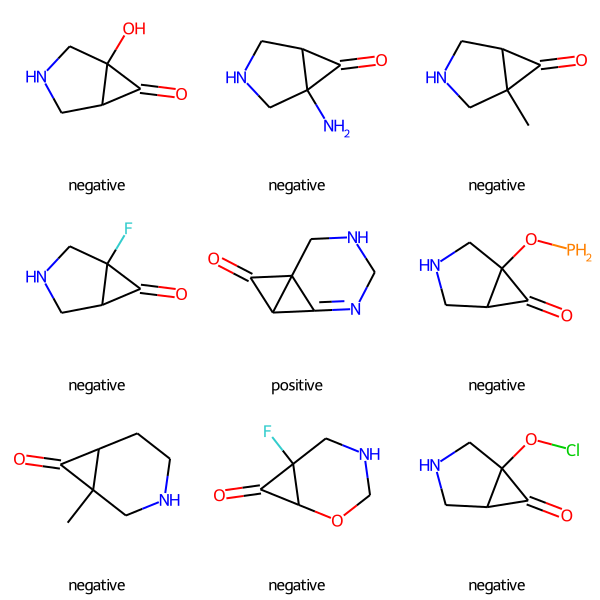

In [9]:
from IPython.display import display

for i in range(1, 21):
    
    if test_set_data[i][2] == '1':
        display(run_exp(test_set_data[i][1], use_instance_as_starting_point=False))

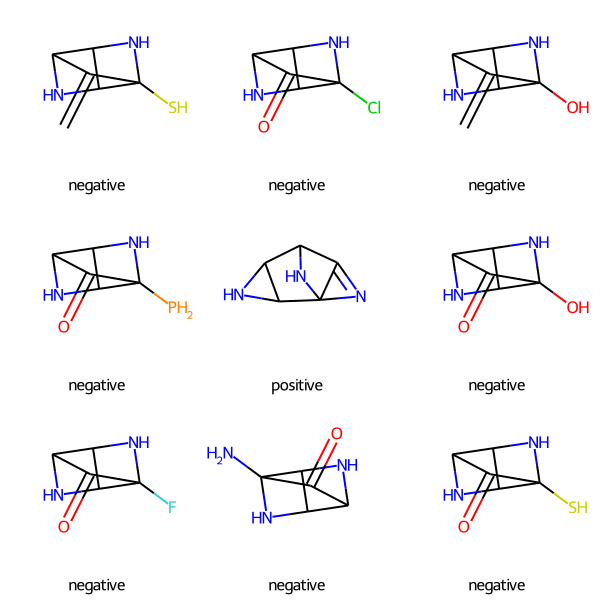

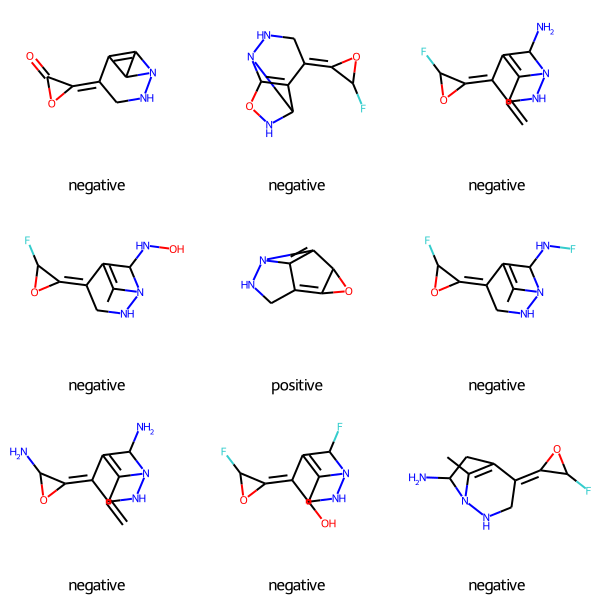

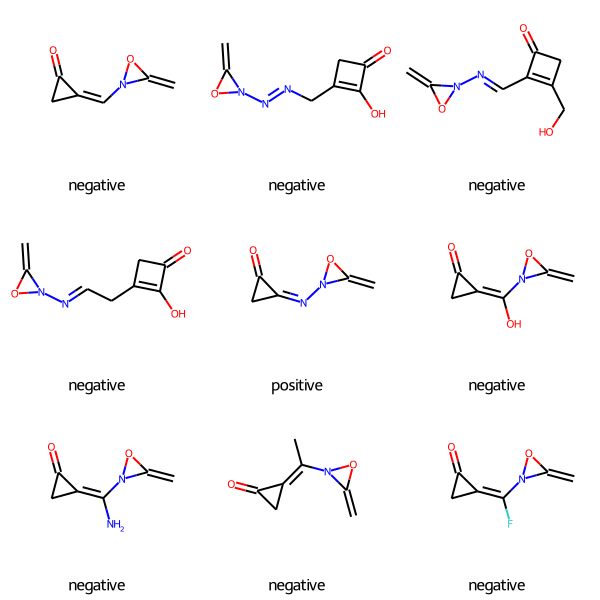

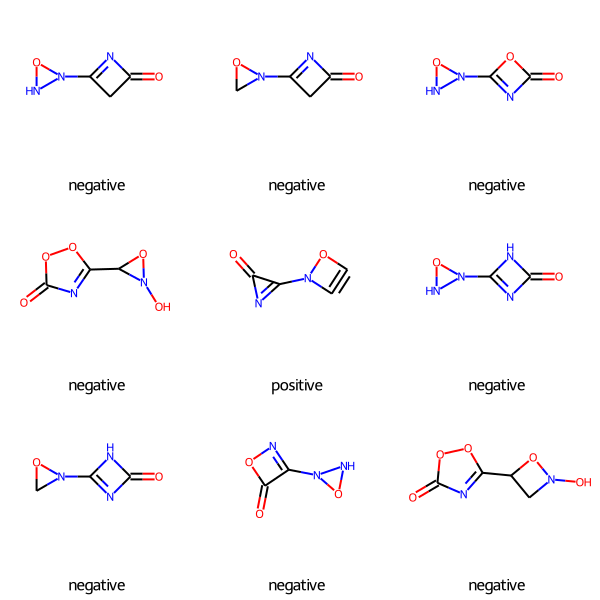

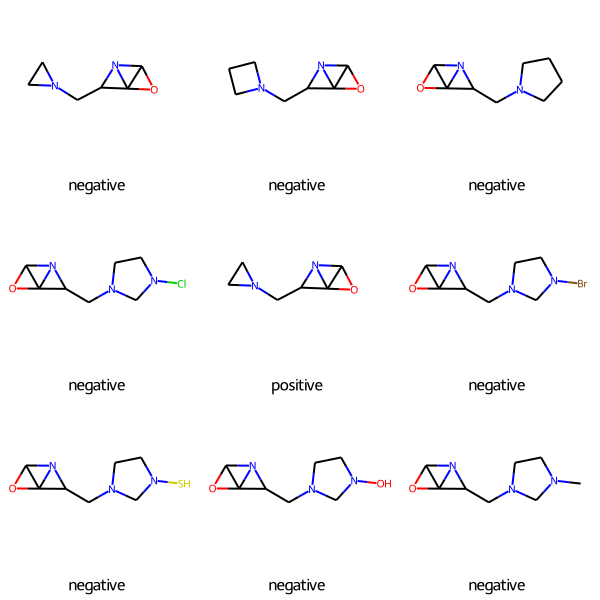

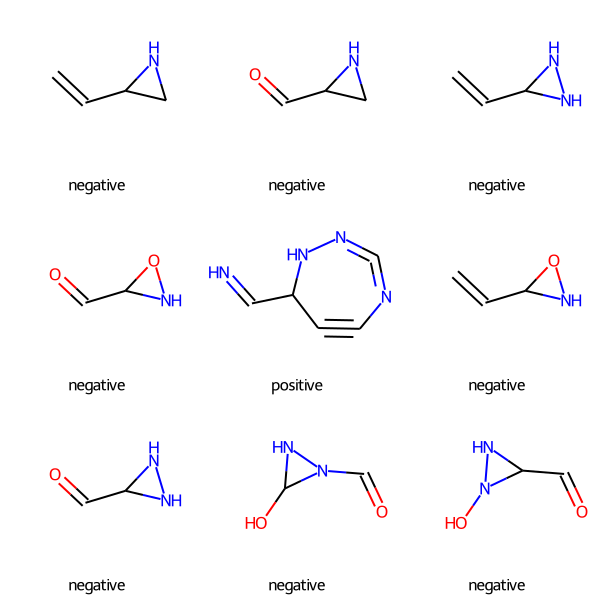

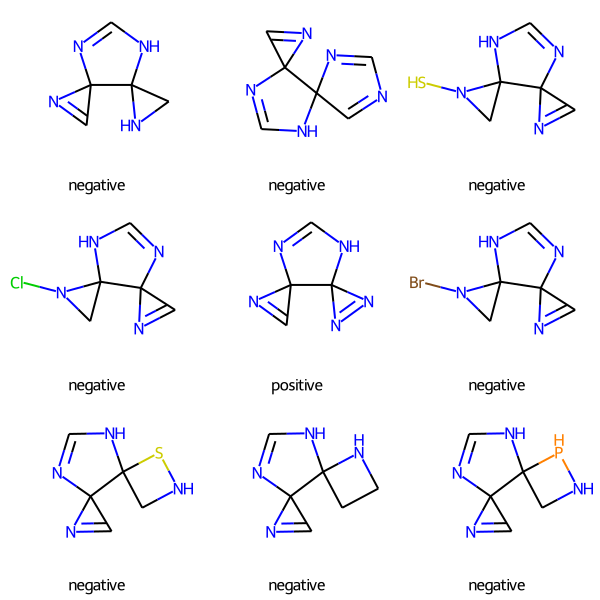

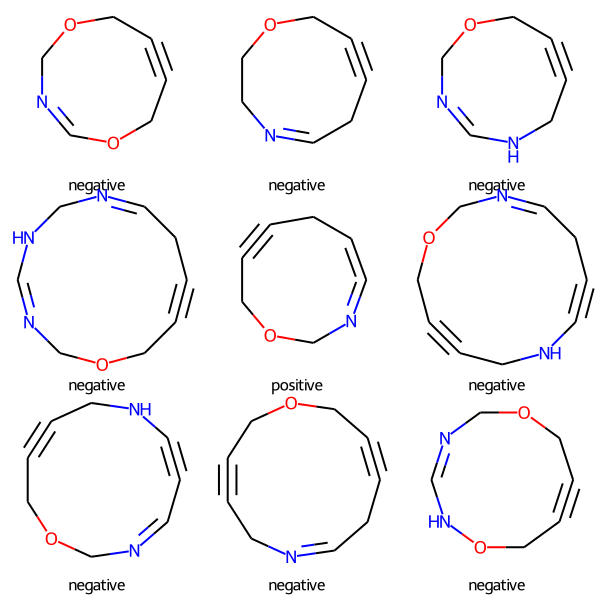

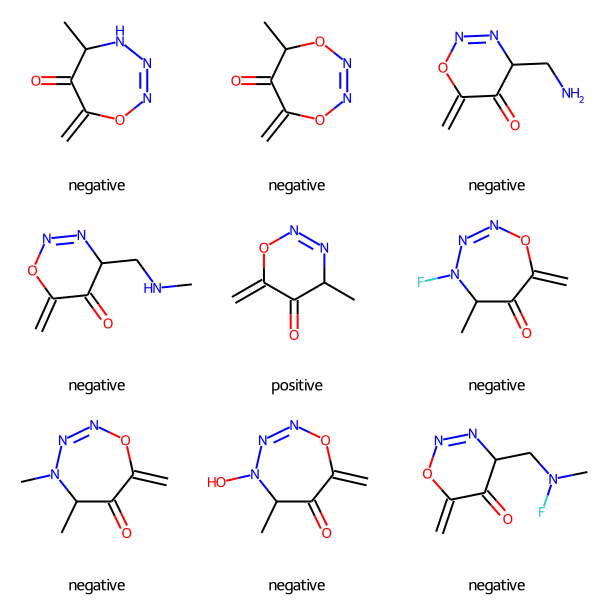

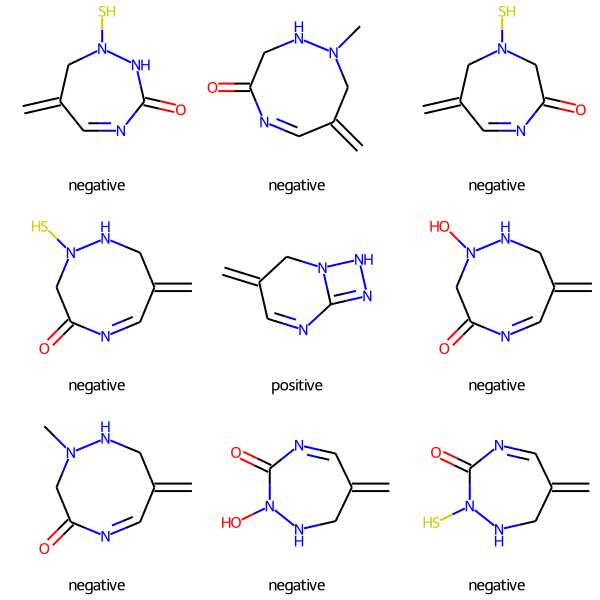

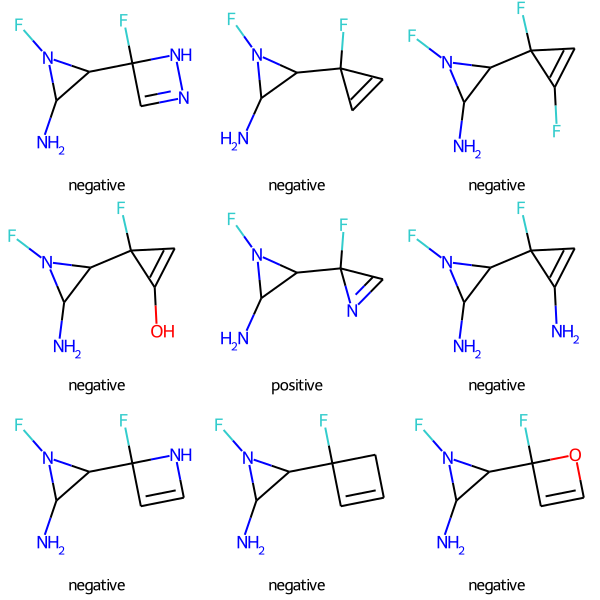

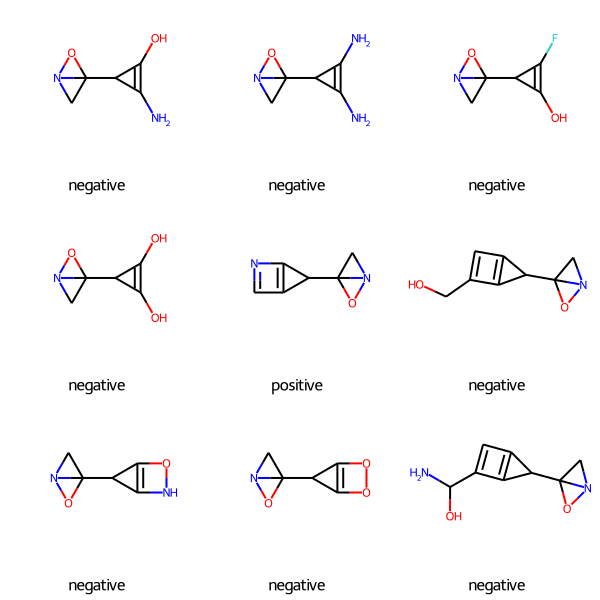

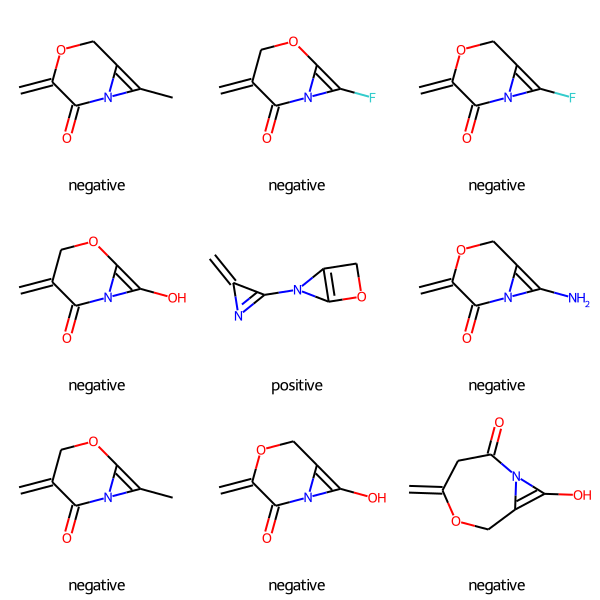

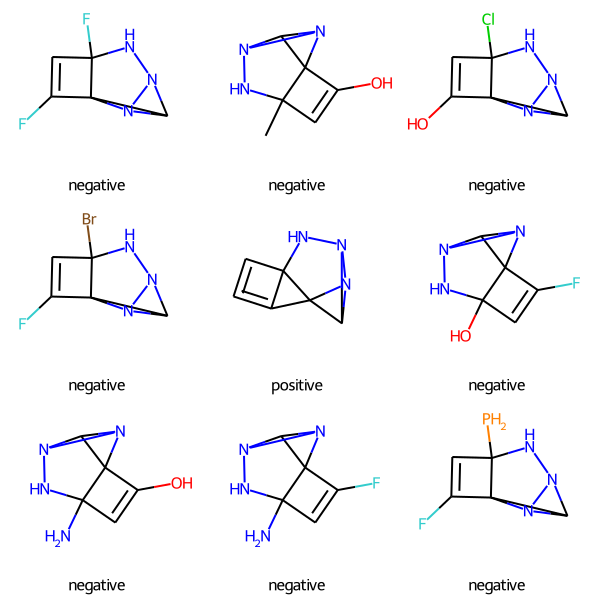

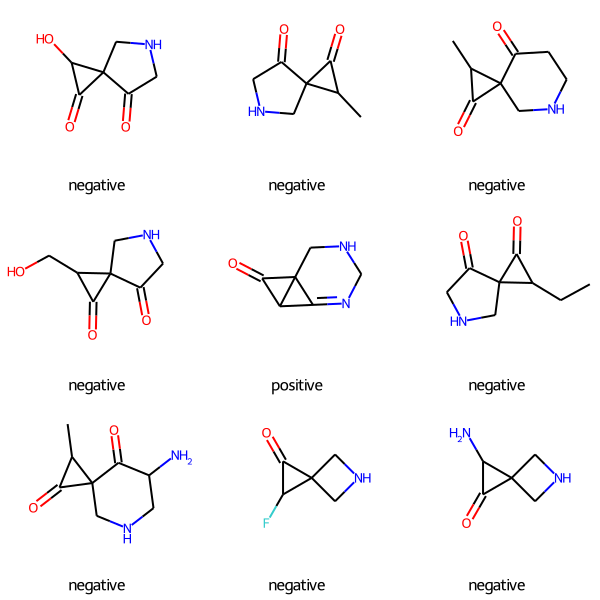

In [11]:
from IPython.display import display

for i in range(1, 21):
    
    if test_set_data[i][2] == '1':
        display(run_exp(test_set_data[i][1], use_instance_as_starting_point=True))